In [1]:
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM

In [2]:
local_zip = '/content/room_occupancy_estimation.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
os.listdir()

['.config',
 'room_occupancy_estimation.zip',
 'Occupancy_Estimation.csv',
 'sample_data']

In [4]:
df = pd.read_csv('/content/Occupancy_Estimation.csv')
df

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,2018/01/11,08:58:07,25.06,25.13,24.69,25.31,6,7,33,22,0.09,0.04,0.06,0.08,345,0.000000,0,0,0
10125,2018/01/11,08:58:37,25.06,25.06,24.69,25.25,6,7,34,22,0.07,0.05,0.05,0.08,345,0.000000,0,0,0
10126,2018/01/11,08:59:08,25.13,25.06,24.69,25.25,6,7,34,22,0.11,0.05,0.06,0.08,345,0.000000,0,0,0
10127,2018/01/11,08:59:39,25.13,25.06,24.69,25.25,6,7,34,22,0.08,0.08,0.10,0.08,345,0.000000,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  10129 non-null  object 
 1   Time                  10129 non-null  object 
 2   S1_Temp               10129 non-null  float64
 3   S2_Temp               10129 non-null  float64
 4   S3_Temp               10129 non-null  float64
 5   S4_Temp               10129 non-null  float64
 6   S1_Light              10129 non-null  int64  
 7   S2_Light              10129 non-null  int64  
 8   S3_Light              10129 non-null  int64  
 9   S4_Light              10129 non-null  int64  
 10  S1_Sound              10129 non-null  float64
 11  S2_Sound              10129 non-null  float64
 12  S3_Sound              10129 non-null  float64
 13  S4_Sound              10129 non-null  float64
 14  S5_CO2                10129 non-null  int64  
 15  S5_CO2_Slope       

In [6]:
df.isnull().sum()

Date                    0
Time                    0
S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
dtype: int64

In [7]:
df['DateTime'] = df['Date'] + " " + df['Time']
df

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count,DateTime
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1,2017/12/22 10:49:41
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1,2017/12/22 10:50:12
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1,2017/12/22 10:50:42
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1,2017/12/22 10:51:13
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1,2017/12/22 10:51:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,2018/01/11,08:58:07,25.06,25.13,24.69,25.31,6,7,33,22,0.09,0.04,0.06,0.08,345,0.000000,0,0,0,2018/01/11 08:58:07
10125,2018/01/11,08:58:37,25.06,25.06,24.69,25.25,6,7,34,22,0.07,0.05,0.05,0.08,345,0.000000,0,0,0,2018/01/11 08:58:37
10126,2018/01/11,08:59:08,25.13,25.06,24.69,25.25,6,7,34,22,0.11,0.05,0.06,0.08,345,0.000000,0,0,0,2018/01/11 08:59:08
10127,2018/01/11,08:59:39,25.13,25.06,24.69,25.25,6,7,34,22,0.08,0.08,0.10,0.08,345,0.000000,0,0,0,2018/01/11 08:59:39


In [8]:
df_s1_temp = df[['S1_Temp']].values
min_max_scaler = MinMaxScaler().fit(df_s1_temp)
df_s1_temp = min_max_scaler.transform(df_s1_temp)
df_s1_temp_val_norm = df_s1_temp.ravel()
df['S1_Temp_Norm'] = df_s1_temp_val_norm
df

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,...,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count,DateTime,S1_Temp_Norm
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,...,0.19,0.06,0.06,390,0.769231,0,0,1,2017/12/22 10:49:41,0.000000
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,...,0.05,0.06,0.06,390,0.646154,0,0,1,2017/12/22 10:50:12,0.000000
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,...,0.11,0.08,0.06,390,0.519231,0,0,1,2017/12/22 10:50:42,0.041667
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,...,0.10,0.10,0.09,390,0.388462,0,0,1,2017/12/22 10:51:13,0.041667
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,...,0.06,0.06,0.06,390,0.253846,0,0,1,2017/12/22 10:51:44,0.041667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,2018/01/11,08:58:07,25.06,25.13,24.69,25.31,6,7,33,22,...,0.04,0.06,0.08,345,0.000000,0,0,0,2018/01/11 08:58:07,0.083333
10125,2018/01/11,08:58:37,25.06,25.06,24.69,25.25,6,7,34,22,...,0.05,0.05,0.08,345,0.000000,0,0,0,2018/01/11 08:58:37,0.083333
10126,2018/01/11,08:59:08,25.13,25.06,24.69,25.25,6,7,34,22,...,0.05,0.06,0.08,345,0.000000,0,0,0,2018/01/11 08:59:08,0.131944
10127,2018/01/11,08:59:39,25.13,25.06,24.69,25.25,6,7,34,22,...,0.08,0.10,0.08,345,0.000000,0,0,0,2018/01/11 08:59:39,0.131944


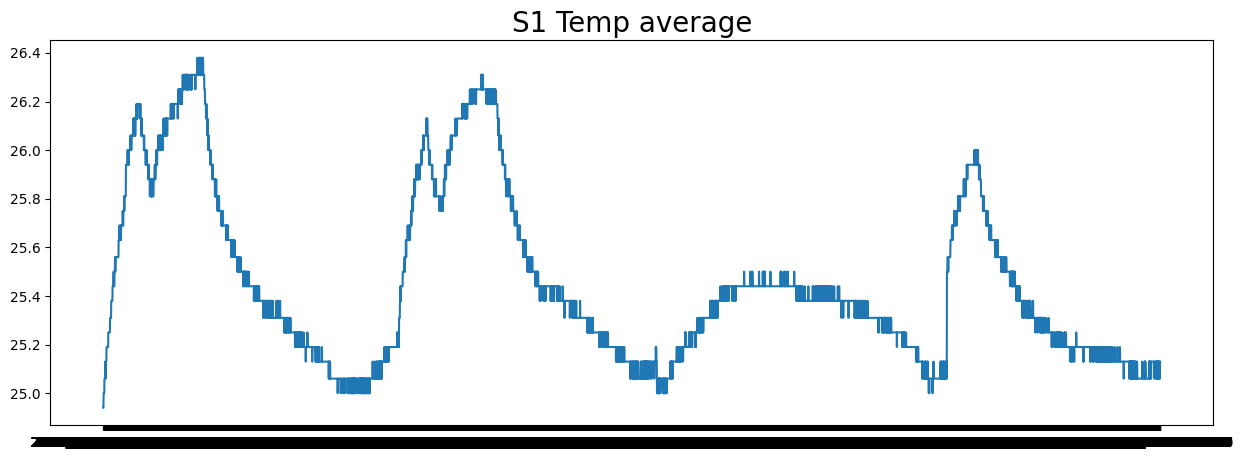

In [9]:
times_df = df['DateTime'].values
temp_df = df['S1_Temp'].values

plt.figure(figsize=(15,5))
plt.plot(times_df, temp_df)
plt.title('S1 Temp average', fontsize=20);

In [10]:
columns_to_drop = ['Date', 'Time', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
                   'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR', 'Room_Occupancy_Count']

df_data = df.drop(columns=columns_to_drop)
df_data

,DateTime,S1_Temp_Norm
0,2017/12/22 10:49:41,0.000000
1,2017/12/22 10:50:12,0.000000
2,2017/12/22 10:50:42,0.041667
3,2017/12/22 10:51:13,0.041667
4,2017/12/22 10:51:44,0.041667
...,...,...
10124,2018/01/11 08:58:07,0.083333
10125,2018/01/11 08:58:37,0.083333
10126,2018/01/11 08:59:08,0.131944
10127,2018/01/11 08:59:39,0.131944


In [11]:
data_train, data_val = train_test_split(df_data, test_size=0.20, shuffle=False)

In [12]:
data_train

,DateTime,S1_Temp_Norm
0,2017/12/22 10:49:41,0.000000
1,2017/12/22 10:50:12,0.000000
2,2017/12/22 10:50:42,0.041667
3,2017/12/22 10:51:13,0.041667
4,2017/12/22 10:51:44,0.041667
...,...,...
8098,2018/01/10 15:32:57,0.388889
8099,2018/01/10 15:33:28,0.430556
8100,2018/01/10 15:33:58,0.430556
8101,2018/01/10 15:34:29,0.430556


In [13]:
data_val

,DateTime,S1_Temp_Norm
8103,2018/01/10 15:35:30,0.430556
8104,2018/01/10 15:36:01,0.430556
8105,2018/01/10 15:36:31,0.430556
8106,2018/01/10 15:37:02,0.430556
8107,2018/01/10 15:37:33,0.430556
...,...,...
10124,2018/01/11 08:58:07,0.083333
10125,2018/01/11 08:58:37,0.083333
10126,2018/01/11 08:59:08,0.131944
10127,2018/01/11 08:59:39,0.131944


In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [15]:
temp_train  = data_train['S1_Temp_Norm'].values
temp_val  = data_val['S1_Temp_Norm'].values
train_set = windowed_dataset(temp_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(temp_val, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [16]:
temp_train_max = temp_train.max()
temp_train_max

1.0

In [17]:
temp_train_min = temp_train.min()
temp_train_min

0.0

In [18]:
threshold_mae = (temp_train_max - temp_train_min) * 0.08
threshold_mae

0.08

In [19]:
class ModelCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('mae') < threshold_mae and logs.get('val_mae') < threshold_mae:
            self.model.stop_training = True

In [20]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(
    train_set,
    batch_size=32,
    epochs=200,
    validation_data=val_set,
    verbose=2,
    callbacks=ModelCallback())

Epoch 1/200
81/81 - 10s - loss: 0.0823 - mae: 0.3131 - val_loss: 0.0285 - val_mae: 0.1697 - 10s/epoch - 118ms/step
Epoch 2/200
81/81 - 3s - loss: 0.0553 - mae: 0.2341 - val_loss: 0.0172 - val_mae: 0.1226 - 3s/epoch - 33ms/step
Epoch 3/200
81/81 - 2s - loss: 0.0405 - mae: 0.1961 - val_loss: 0.0131 - val_mae: 0.1229 - 2s/epoch - 25ms/step
Epoch 4/200
81/81 - 2s - loss: 0.0331 - mae: 0.1792 - val_loss: 0.0120 - val_mae: 0.1299 - 2s/epoch - 25ms/step
Epoch 5/200
81/81 - 2s - loss: 0.0289 - mae: 0.1729 - val_loss: 0.0120 - val_mae: 0.1362 - 2s/epoch - 25ms/step
Epoch 6/200
81/81 - 4s - loss: 0.0267 - mae: 0.1714 - val_loss: 0.0122 - val_mae: 0.1404 - 4s/epoch - 45ms/step
Epoch 7/200
81/81 - 2s - loss: 0.0253 - mae: 0.1707 - val_loss: 0.0124 - val_mae: 0.1430 - 2s/epoch - 28ms/step
Epoch 8/200
81/81 - 2s - loss: 0.0243 - mae: 0.1703 - val_loss: 0.0125 - val_mae: 0.1442 - 2s/epoch - 24ms/step
Epoch 9/200
81/81 - 2s - loss: 0.0238 - mae: 0.1698 - val_loss: 0.0126 - val_mae: 0.1446 - 2s/epoch -

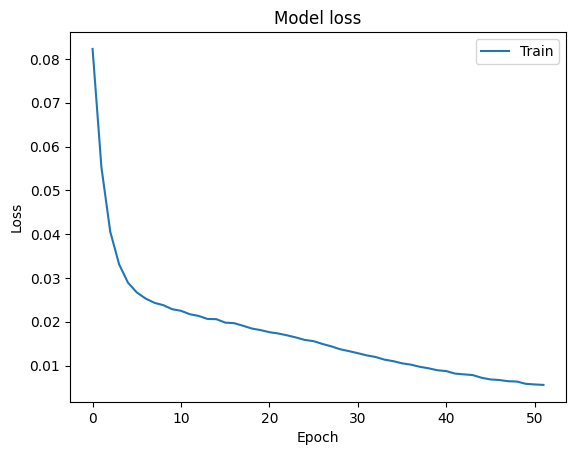

In [21]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

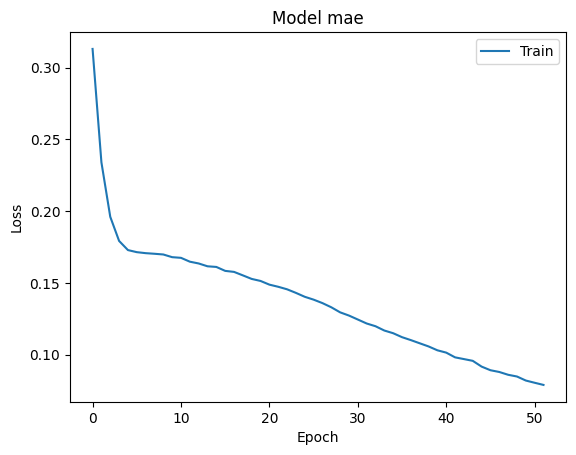

In [22]:
plt.plot(history.history['mae'])
plt.title('Model mae')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

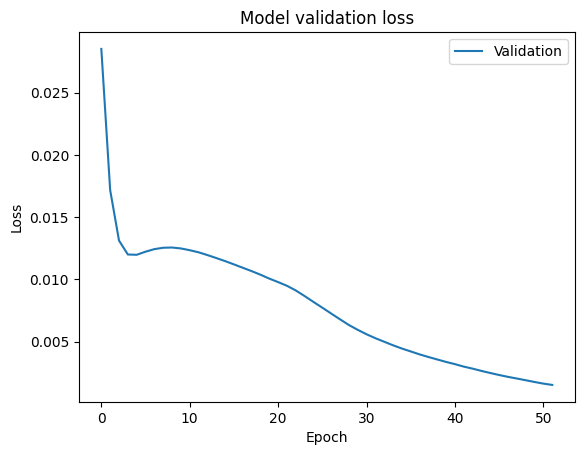

In [23]:
plt.plot(history.history['val_loss'])
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper right')
plt.show()

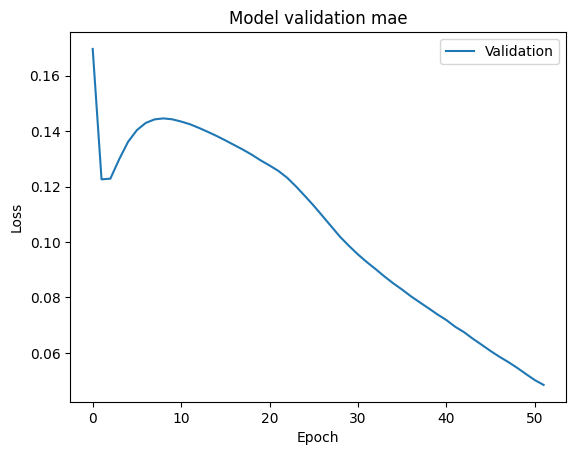

In [24]:
plt.plot(history.history['val_mae'])
plt.title('Model validation mae')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper right')
plt.show()